Задача 5. Обучение без учителя\
 -- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.\
 -- Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.\
 -- Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
 -- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).\
 При обучении использовать подбор гиперпараметров.\
 -- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.\
 -- Также снизить размерность данных с помощью метода главных компонент PCA и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.\
 -- Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой-то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib
import csv

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

In [3]:
df = pd.read_csv('test_data.csv', on_bad_lines='skip')

This is a Hiragana character dataset.\
Contains 28x28 images of hiragana characters.\
There are 10 classes.


1.   Aa
2.   Ka
3.   Sa
4.   Ta
5.   Na
6.   Ha
7.   Ma
8.   Ya
9.   Ra
10.  Wa




In [4]:
df.head()

,Unnamed: 0,label,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,0,2,0,97,35,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,24,72,0,...,251,149,1,0,0,0,0,0,0,0
2,2,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,8,0,0,0,0,0,17,138,195,...,0,0,0,0,0,0,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df["label"].value_counts()

label
2    1000
9    1000
3    1000
8    1000
5    1000
6    1000
1    1000
4    1000
7    1000
0    1000
Name: count, dtype: int64

In [6]:
labels = df["label"]
df.drop(columns=["label", "Unnamed: 0"], inplace=True)

In [7]:
%%time
from sklearn.decomposition import PCA

pca = PCA(n_components=90)
pca_result = pca.fit_transform(df)

CPU times: user 1.92 s, sys: 893 ms, total: 2.81 s
Wall time: 3.61 s


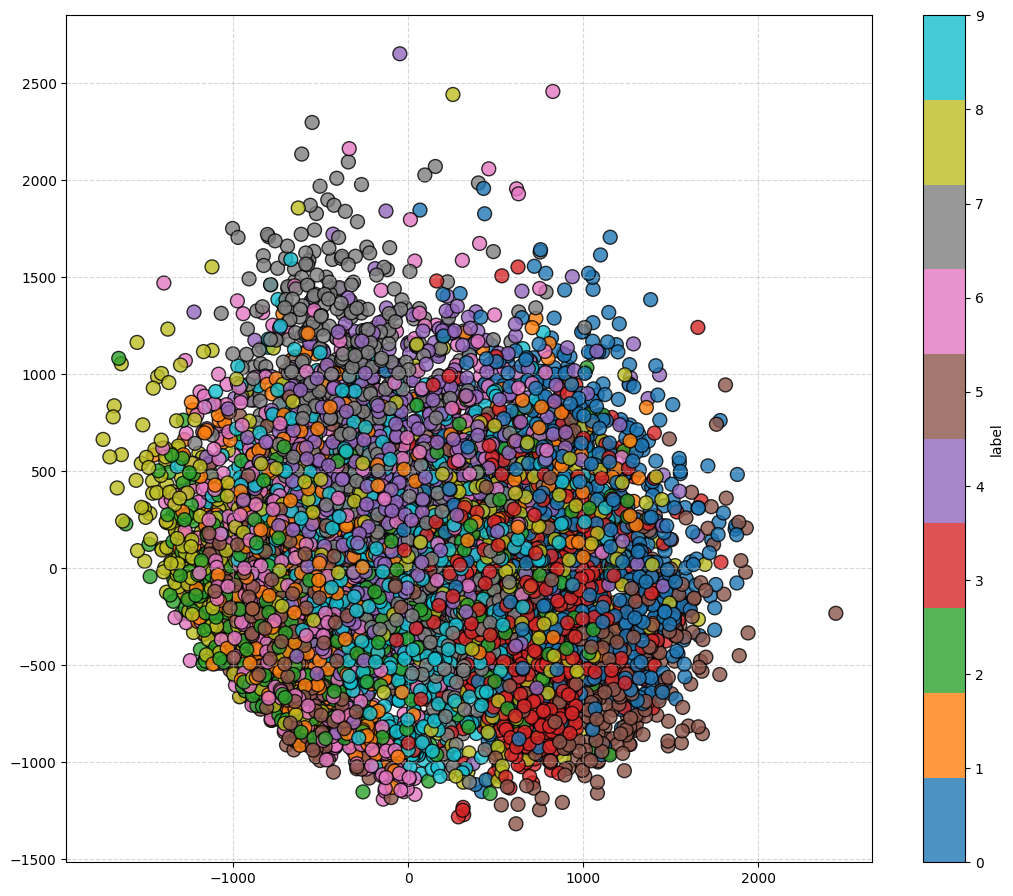

In [8]:
plt.figure(figsize=(13, 11))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels,
            edgecolor='black', alpha=0.8, s=100, cmap='tab10')
plt.colorbar(label='label')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [9]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42)
df_reduced = tsne.fit_transform(df)

CPU times: user 3min 38s, sys: 559 ms, total: 3min 38s
Wall time: 2min 18s


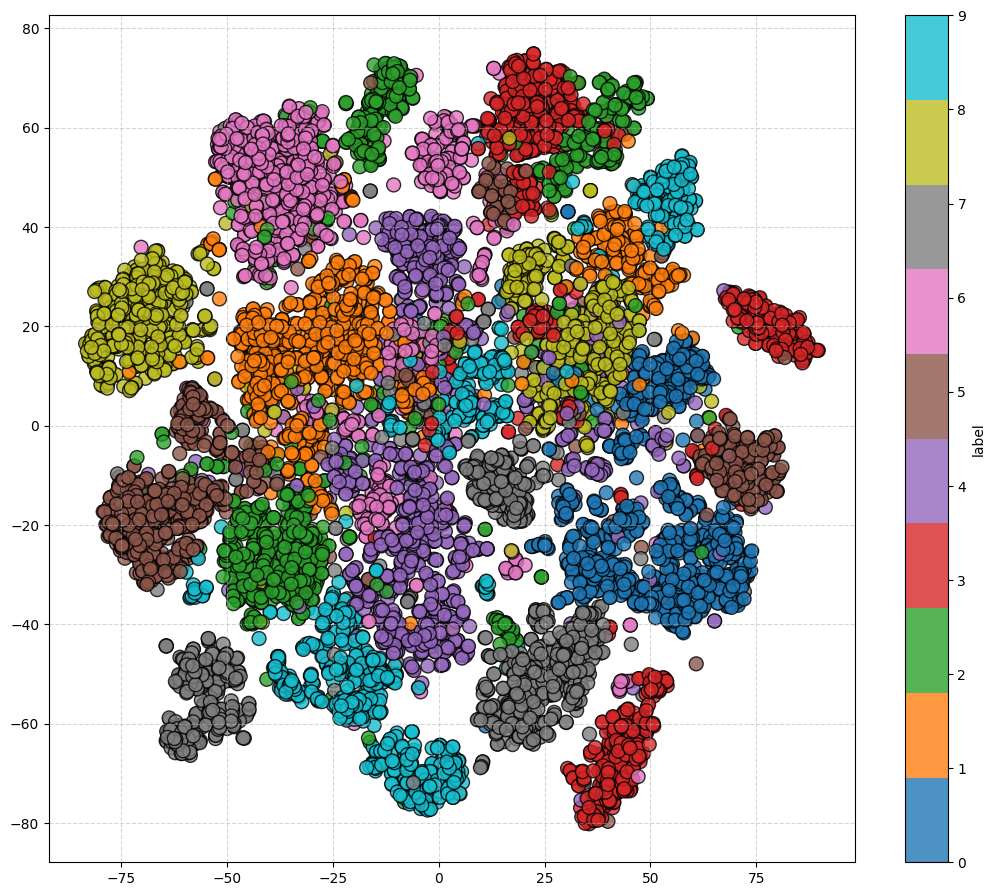

In [10]:
plt.figure(figsize=(13, 11))
plt.scatter(df_reduced[:, 0], df_reduced[:, 1], c=labels,
            edgecolor='black', alpha=0.8, s=100, cmap='tab10')
plt.colorbar(label='label')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

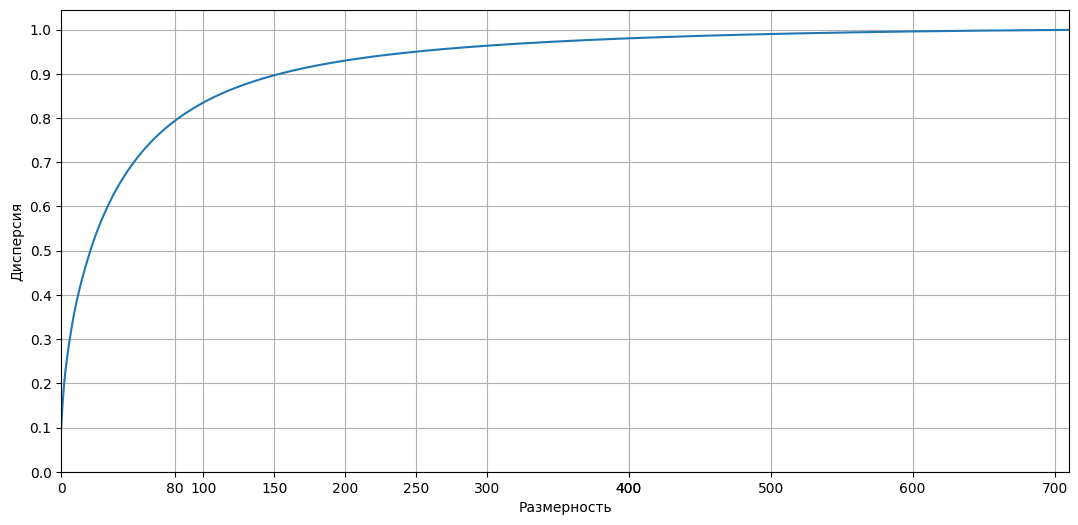

In [82]:
plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [80, 150, 250, 400])
plt.xlim(0, 710)
plt.grid(True)

Видно, что 80 признаков позволяет описать 80% дисперсии, 150 около 85%, 250 около 90%, а начиная с 400 добавление новых признаков практически не приносит новой информации.

Будем использовать метрики:
1. Adjusted Rand Index (ARI)
2. Adjusted Mutual Information (AMI)
3. Fowlkes-Mallows Index (FMI)

In [35]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted

class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None):
        X = check_array(X)
        random_state = check_random_state(self.random_state)

        self.cluster_centers_ = X[random_state.choice(len(X), size=self.n_clusters, replace=False)]

        while True:
            distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
            labels = np.argmin(distances, axis=1)
            new_centers = np.array([np.mean(X[labels == k], axis=0) for k in range(self.n_clusters)])

            if np.max(np.linalg.norm(new_centers - self.cluster_centers_, axis=1)) < self.tol:
                break

            self.cluster_centers_ = new_centers

        self.labels_ = labels

        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        labels = np.argmin(distances, axis=1)

        return labels

In [83]:
%%time
xs = [df, *(PCA(n_components=i).fit_transform(df) for i in [70, 150, 250, 400])]

CPU times: user 10.7 s, sys: 213 ms, total: 10.9 s
Wall time: 11.2 s


In [36]:
import itertools
import numpy as np
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone
import time

def train(estimator, params):
    results = []

    param_combinations = list(itertools.product(*params.values()))

    for x in xs:
        best_ari = -np.inf
        best_ami = -np.inf
        best_fmi = -np.inf
        best_params_ari = None
        best_params_ami = None
        best_params_fmi = None

        for param_values in param_combinations:
            param_dict = dict(zip(params.keys(), param_values))
            estimator_instance = clone(estimator).set_params(**param_dict)

            start_time = time.perf_counter()
            pred = estimator_instance.fit_predict(x)
            pred_time = time.perf_counter() - start_time

            ari = adjusted_rand_score(labels, pred)
            ami = adjusted_mutual_info_score(labels, pred)
            fmi = fowlkes_mallows_score(labels, pred)

            if ari > best_ari:
                best_ari = ari
                best_params_ari = param_dict

            if ami > best_ami:
                best_ami = ami
                best_params_ami = param_dict

            if fmi > best_fmi:
                best_fmi = fmi
                best_params_fmi = param_dict

        res = {
            "Cluster": estimator.__class__.__name__,
            "Dimensions": x.shape[1],
            "Mean fit predict time, s": (pred_time),
            "Best ARI": best_ari,
            "Best AMI": best_ami,
            "Best FMI": best_fmi
        }

        print(f"Best params for {x.shape[1]} dimensions:")
        print(f"By ARI: {best_params_ari}")
        print(f"By AMI: {best_params_ami}")
        print(f"By FMI: {best_params_fmi}")

        print(res)
        results.append(res)

    return results

In [71]:
%%time
my_kmeans = train(
    MyKMeans(n_clusters=10, random_state=0),
    params={}
)

Best params for 784 dimensions:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'MyKMeans', 'Dimensions': 784, 'Mean fit predict time, s': 27.96913026999937, 'Best ARI': 0.20300231380091724, 'Best AMI': 0.3056337843806499, 'Best FMI': 0.2838581358233749}
Best params for 70 dimensions:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'MyKMeans', 'Dimensions': 70, 'Mean fit predict time, s': 3.347433934000037, 'Best ARI': 0.19551505189691512, 'Best AMI': 0.3070860303617466, 'Best FMI': 0.27714690088251365}
Best params for 150 dimensions:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'MyKMeans', 'Dimensions': 150, 'Mean fit predict time, s': 4.904198455999904, 'Best ARI': 0.19462669841636904, 'Best AMI': 0.3037032245313796, 'Best FMI': 0.27668407263765926}
Best params for 250 dimensions:
By ARI: {}
By AMI: {}
By FMI: {}
{'Cluster': 'MyKMeans', 'Dimensions': 250, 'Mean fit predict time, s': 9.044728775999829, 'Best ARI': 0.1918867733409955, 'Best AMI': 0.3008224737106921, 'Best FMI': 0.27432047301

In [72]:
%%time
from sklearn.cluster import KMeans

kmeans = train(
    KMeans(n_clusters=10, n_init='auto', random_state=0),
    params={"algorithm": ["lloyd", "elkan"]}
)

Best params for 784 dimensions:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 784, 'Mean fit predict time, s': 1.7797949120003977, 'Best ARI': 0.190099399984018, 'Best AMI': 0.3107357021366295, 'Best FMI': 0.2739855569334575}
Best params for 70 dimensions:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 70, 'Mean fit predict time, s': 0.11678427700007887, 'Best ARI': 0.18649958506920566, 'Best AMI': 0.31020879947595426, 'Best FMI': 0.27511610253058394}
Best params for 150 dimensions:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}
{'Cluster': 'KMeans', 'Dimensions': 150, 'Mean fit predict time, s': 0.1968026029999237, 'Best ARI': 0.19380109974830728, 'Best AMI': 0.30924050277040055, 'Best FMI': 0.2781540311046776}
Best params for 250 dimensions:
By ARI: {'algorithm': 'lloyd'}
By A

In [74]:
%%time
from sklearn.cluster import DBSCAN

dbscan = train(
    DBSCAN(n_jobs=4),
    params={
        "eps": [0.5, 0.75, 1, 2, 5],
        "min_samples": [2, 3, 5, 10, 20],
    }
)

Best params for 784 dimensions:
By ARI: {'eps': 0.5, 'min_samples': 2}
By AMI: {'eps': 0.5, 'min_samples': 2}
By FMI: {'eps': 0.5, 'min_samples': 2}
{'Cluster': 'DBSCAN', 'Dimensions': 784, 'Mean fit predict time, s': 8.194253294999726, 'Best ARI': 0.0, 'Best AMI': 0.0, 'Best FMI': 0.31608541725157124}
Best params for 70 dimensions:
By ARI: {'eps': 0.5, 'min_samples': 2}
By AMI: {'eps': 0.5, 'min_samples': 2}
By FMI: {'eps': 0.5, 'min_samples': 2}
{'Cluster': 'DBSCAN', 'Dimensions': 70, 'Mean fit predict time, s': 0.6447422749997713, 'Best ARI': 0.0, 'Best AMI': 0.0, 'Best FMI': 0.31608541725157124}
Best params for 150 dimensions:
By ARI: {'eps': 0.5, 'min_samples': 2}
By AMI: {'eps': 0.5, 'min_samples': 2}
By FMI: {'eps': 0.5, 'min_samples': 2}
{'Cluster': 'DBSCAN', 'Dimensions': 150, 'Mean fit predict time, s': 1.997665467999468, 'Best ARI': 0.0, 'Best AMI': 0.0, 'Best FMI': 0.31608541725157124}
Best params for 250 dimensions:
By ARI: {'eps': 0.5, 'min_samples': 2}
By AMI: {'eps': 0.

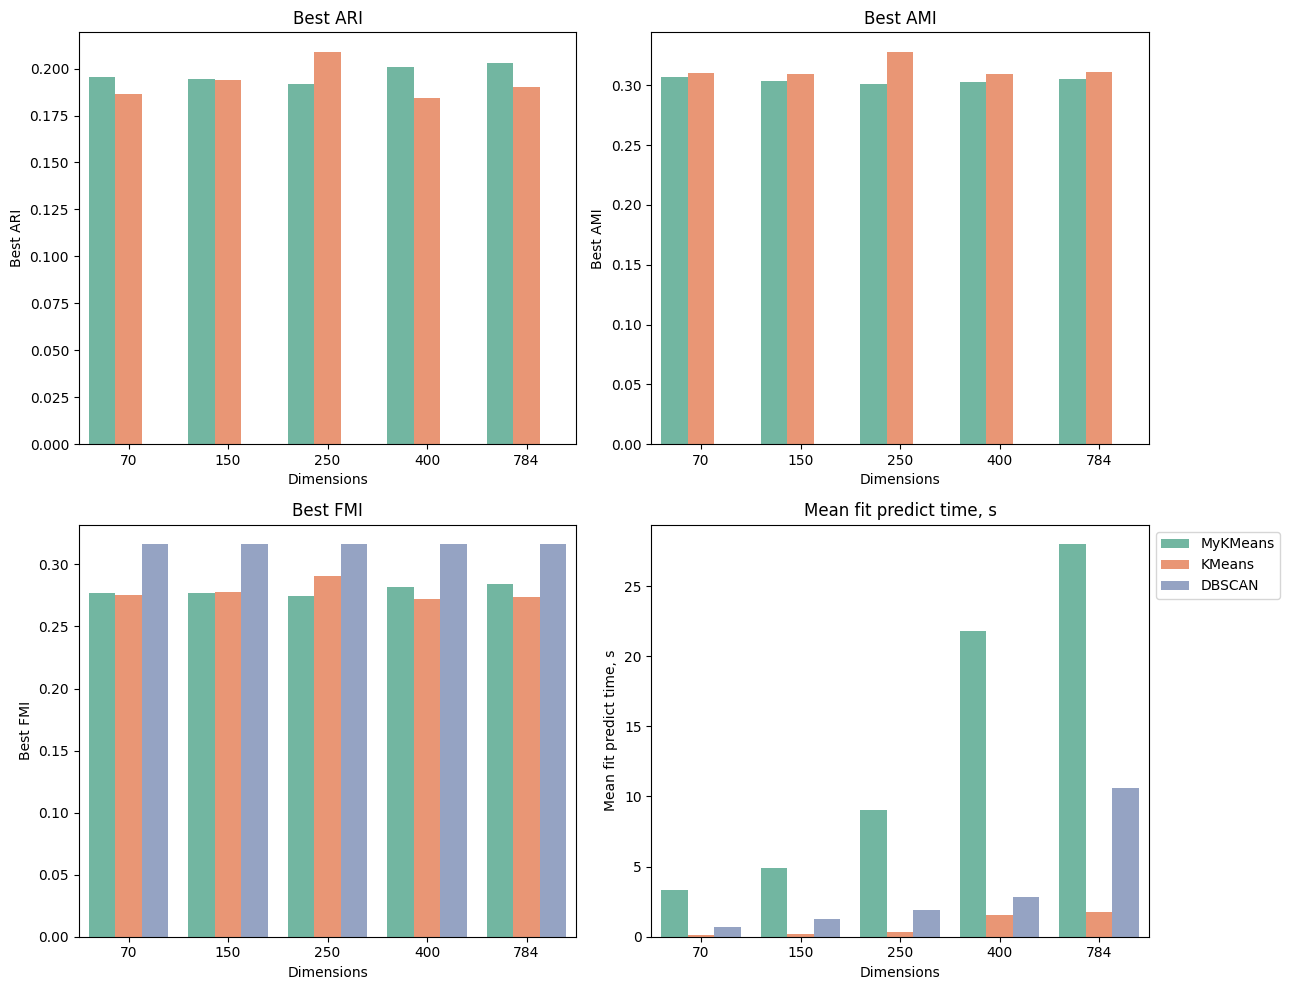

In [73]:
results = pd.DataFrame(my_kmeans + kmeans + dbscan)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(13, 10))
palette = "Set2"

for metric, ax in zip(["Best ARI", "Best AMI", "Best FMI", "Mean fit predict time, s"], axs.flatten()):
    sns.barplot(data=results, x="Dimensions", y=metric, hue="Cluster", ax=ax, palette=palette)

    if metric == "Mean fit predict time, s":
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

    ax.set_title(metric)

fig.tight_layout()

plt.show()

KMeans от sklearn обучается быстрее чем DBSCAN\
На данных из датасета Japanese Characters хуже всего себя показала модель DBSCAN